# EC7212 – Computer Vision and Image Processing - Take Home Assignment 2



## Task 1

#### Consider an image with 2 objects and a total of 3-pixel values (1 for each object and one for the background). Add Gaussian noise to the image. Implement and test Otsu’s algorithm with this image.


### Import libraries

In [7]:
# Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Read and Prepare the Image

In [8]:
input_image = cv2.imread("task1.png")
if input_image is None:
    raise FileNotFoundError("task01_input.png not found!")

# Convert BGR to RGB for visualization
input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

# Convert to grayscale for thresholding
gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)


### Add Gaussian Noise

In [9]:
def add_gaussian_noise(image, mean=0, std=20):
    noise = np.random.normal(mean, std, image.shape).astype(np.int16)
    noisy = image.astype(np.int16) + noise
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

noisy_image = add_gaussian_noise(gray_image)


### Apply Otsu’s Thresholding

In [10]:
def otsu(image):
    histogram, _ = np.histogram(image.ravel(), bins=256, range=(0, 256))
    total_pixels = image.size
    sum_total = np.dot(np.arange(256), histogram)

    sumB = 0
    wB = 0
    max_between_class_variance = 0
    threshold = 0

    for t in range(256):
        wB += histogram[t]
        if wB == 0:
            continue
        wF = total_pixels - wB
        if wF == 0:
            break

        sumB += t * histogram[t]
        mB = sumB / wB
        mF = (sum_total - sumB) / wF

        between_class_variance = wB * wF * (mB - mF) ** 2

        if between_class_variance > max_between_class_variance:
            max_between_class_variance = between_class_variance
            threshold = t

    binary_image = (image >= threshold).astype(np.uint8) * 255
    return threshold, binary_image

otsu_thresh, otsu_result = otsu(noisy_image)


### Display Results

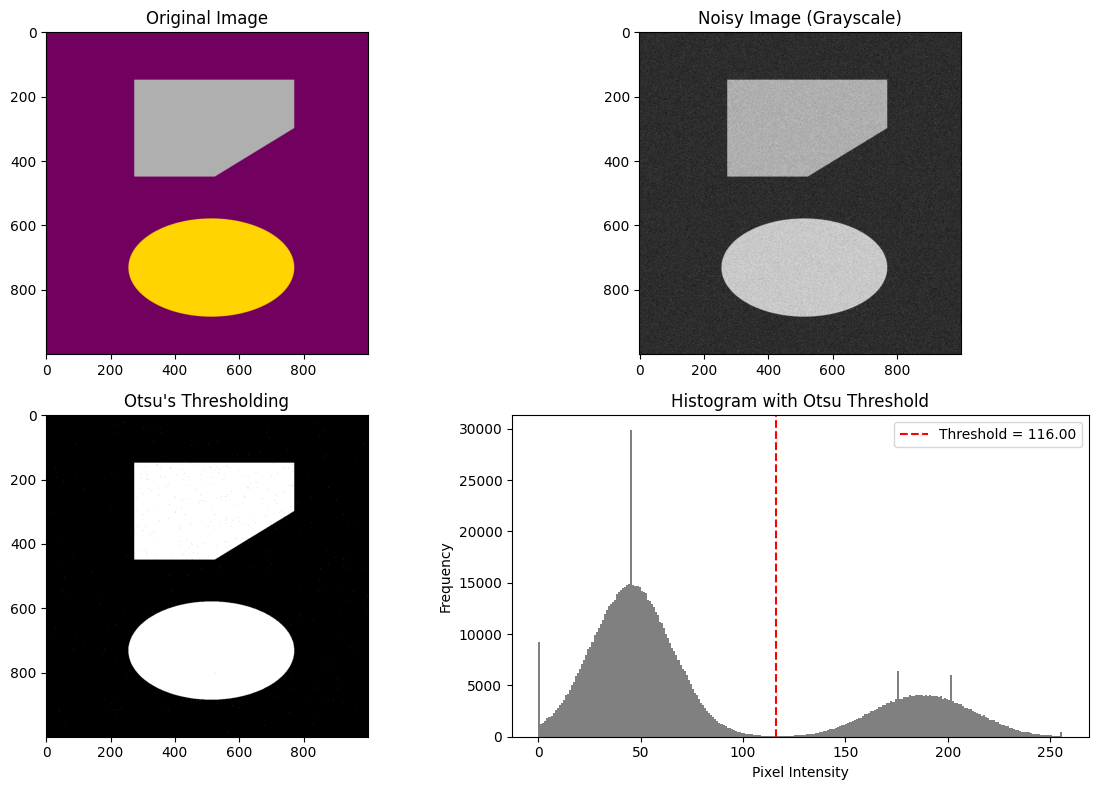

In [11]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(input_image_rgb)

plt.subplot(2, 2, 2)
plt.title("Noisy Image (Grayscale)")
plt.imshow(noisy_image, cmap='gray')

plt.subplot(2, 2, 3)
plt.title("Otsu's Thresholding")
plt.imshow(otsu_result, cmap='gray')

plt.subplot(2, 2, 4)
plt.title("Histogram with Otsu Threshold")
plt.hist(noisy_image.ravel(), bins=256, range=(0, 256), color='gray')
plt.axvline(x=otsu_thresh, color='red', linestyle='--', label=f'Threshold = {otsu_thresh:.2f}')
plt.legend()
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig("task01_output.png", dpi=300)
plt.show()


## Task 2

### Implement a region-growing technique for image segmentation. The basic idea is to start from a set of points inside the object of interest (foreground), denoted as seeds, and recursively add neighboring pixels as long as they are in a pre-defined range of the pixel values of the seeds.

### Load image and apply region growing

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load grayscale image
image = cv2.imread("task02.jpg", cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError("Image not found.")

height, width = image.shape

seed_points = [(555, 310),(1020, 200), (930,705), (440, 120)]


In [ ]:

def region_growing(image, seeds, threshold=25):
    height, width = image.shape
    segmented = np.zeros_like(image, dtype=np.uint8)
    visited = np.zeros_like(image, dtype=bool)
    queue = list(seeds)
    seed_values = [image[y, x] for x, y in seeds]
    mean_value = np.mean(seed_values)

    while queue:
        x, y = queue.pop(0)
        if visited[y, x]:
            continue
        visited[y, x] = True

        current_value = image[y, x]
        if abs(int(current_value) - int(mean_value)) <= threshold:
            segmented[y, x] = 255

            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    if dx == 0 and dy == 0:
                        continue
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < width and 0 <= ny < height and not visited[ny, nx]:
                        queue.append((nx, ny))

    return segmented

segmented_mask = region_growing(image, seed_points, threshold=25)

image_marked = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
for x, y in seed_points:
    cv2.circle(image_marked, (x, y), radius=5, color=(255, 0, 0), thickness=-1)

overlay = cv2.addWeighted(image_marked, 0.7,
                        cv2.cvtColor(segmented_mask, cv2.COLOR_GRAY2BGR), 0.6, 0)


### Plot the results

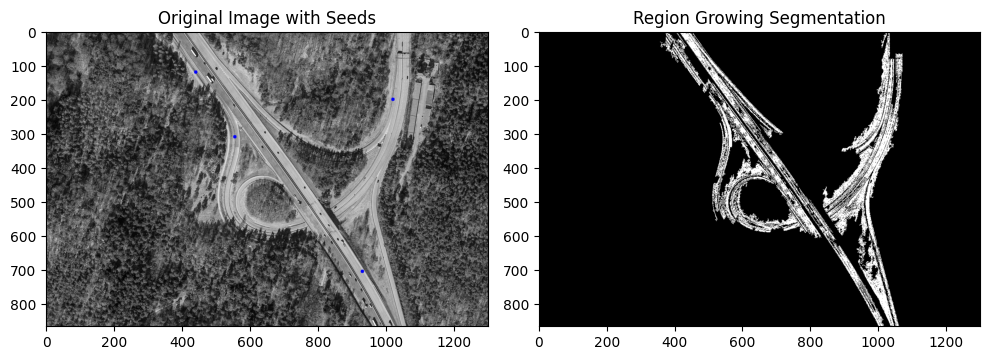

In [14]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image with Seeds")
plt.imshow(cv2.cvtColor(image_marked, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Region Growing Segmentation")
plt.imshow(segmented_mask, cmap='gray')

plt.tight_layout()
plt.savefig("task02_output.png", dpi=300)
plt.show()

